[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.org/github/hamish-smeele/Portfolio/blob/main/Red_Snowfall.ipynb)

## EDA with Red Resort Snowfall Data

__Objectives:__
1. Determine which season has the highest snowfall and how this compares to average
2. Investigate highest average snowfall periods: (a) Two week period. (b) One week period.
3. Determine relationship between El Niño-Southern Oscillation (ENSO) and total snowfall over period November - April.


### Objective 1: Determine which season has the highest snowfall and how this compares to average

In [22]:
# Import Required Libraries

import requests
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import monthrange


In [3]:
# Pull Red Resort JSON Files

BASE_URL = "https://api.redresort.com/report/history"
YEARS = range(2004, 2025)  # inclusive of 2024

def fetch_year(year: int) -> pd.DataFrame:
    url = f"{BASE_URL}?year={year}"
    r = requests.get(url, timeout=15)
    r.raise_for_status()
    data = r.json()
    # If the API returns a list of records, json_normalize will convert to rows.
    # Adjust if the structure differs.
    return pd.json_normalize(data).assign(year=year)

frames = []
for y in YEARS:
    try:
        frames.append(fetch_year(y))
    except Exception as exc:
        print(f"Failed for {y}: {exc}")

df = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

df.head()



,WeatherData,RequestedYear,MountainReport.MRID,MountainReport.SkyB,MountainReport.SkyBText,MountainReport.SkyS,MountainReport.SkySText,MountainReport.MetricToday,MountainReport.MetricOvernight,MountainReport.Metric24hours,...,MountainReport.Notes,MountainReport.SummerMode,MountainReport.DateTime,MountainReport.MailingListID,MountainReport.UserID,MountainReport.Lifts,MountainReport.SnowData,MountainReport.HeaderImage,MountainReport.TotalSnowDepth,year
0,None,2004,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2004, 'Total': 4...",,487,2004
1,None,2005,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2005, 'Total': 2...",,781,2005
2,None,2006,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2006, 'Total': 0...",,434,2006
3,None,2007,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2007, 'Total': 0...",,577,2007
4,None,2008,0,0,,0,,0,0,0,...,,False,0001-01-01T00:00:00Z,0,0,None,"[{'Month': 'October', 'Year': 2008, 'Total': 0...",,469,2008


In [4]:
### Remove cols not required from Data Frame

# columns to keep
cols_keep = ["MountainReport.SnowData", "MountainReport.TotalSnowDepth", "year" ]

# select only those columns that exist; drops all others
df = df.loc[:, df.columns.intersection(cols_keep)]

# quick check
df.head()


,MountainReport.SnowData,MountainReport.TotalSnowDepth,year
0,"[{'Month': 'October', 'Year': 2004, 'Total': 4...",487,2004
1,"[{'Month': 'October', 'Year': 2005, 'Total': 2...",781,2005
2,"[{'Month': 'October', 'Year': 2006, 'Total': 0...",434,2006
3,"[{'Month': 'October', 'Year': 2007, 'Total': 0...",577,2007
4,"[{'Month': 'October', 'Year': 2008, 'Total': 0...",469,2008


In [5]:
### Split Data Frame into Season Totals and Daily Snowfall

# columns to keep
daily_cols_keep = ["MountainReport.SnowData"]

# select only those columns that exist; drops all others
df_daily = df.loc[:, df.columns.intersection(daily_cols_keep)]

# columns to keep
totals_cols_keep = ["MountainReport.TotalSnowDepth", "year" ]

# select only those columns that exist; drops all others
df_totals = df.loc[:, df.columns.intersection(totals_cols_keep)]

In [6]:
df_daily.head()

,MountainReport.SnowData
0,"[{'Month': 'October', 'Year': 2004, 'Total': 4..."
1,"[{'Month': 'October', 'Year': 2005, 'Total': 2..."
2,"[{'Month': 'October', 'Year': 2006, 'Total': 0..."
3,"[{'Month': 'October', 'Year': 2007, 'Total': 0..."
4,"[{'Month': 'October', 'Year': 2008, 'Total': 0..."


In [7]:
df_totals.head()

,MountainReport.TotalSnowDepth,year
0,487,2004
1,781,2005
2,434,2006
3,577,2007
4,469,2008


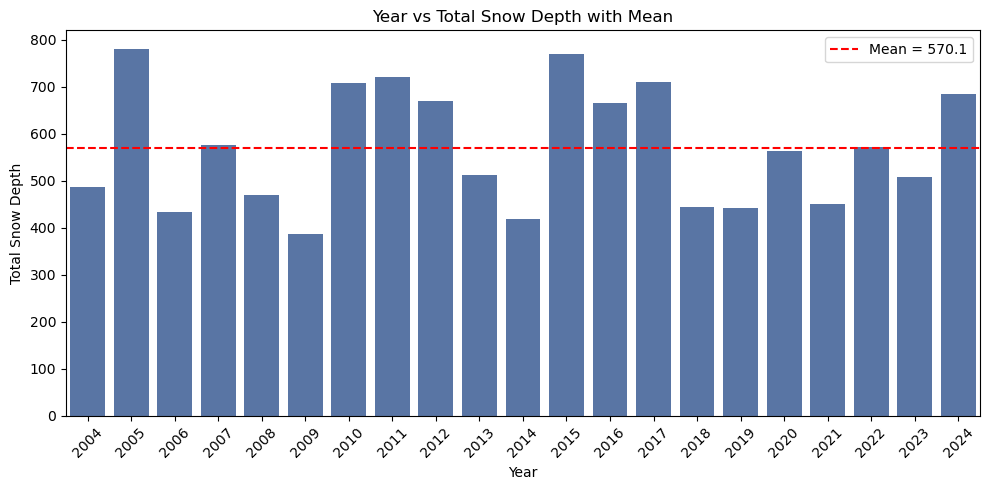

In [8]:
df_totals = df_totals[["year", "MountainReport.TotalSnowDepth"]].dropna()
mean_depth = df_totals["MountainReport.TotalSnowDepth"].mean()

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_totals,
    x="year",
    y="MountainReport.TotalSnowDepth",
    color="#4c72b0",
)
ax.axhline(mean_depth, color="red", linestyle="--", linewidth=1.5, label=f"Mean = {mean_depth:.1f}")
plt.xlabel("Year")
plt.ylabel("Total Snow Depth")
plt.title("Year vs Total Snow Depth with Mean")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Objective 2: Investigate highest snowfall periods

In [9]:
### Examine MountainReport.SnowData to workout how to orgnaise and clean data

# pick one element, e.g., the first non-null
sample = df_daily["MountainReport.SnowData"].dropna().iloc[0]

print(sample)
print(type(sample))

[{'Month': 'October', 'Year': 2004, 'Total': 45, 'DaysInMonth': 31, 'Ceiling': 40, 'Days': {'1': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '2': 0, '20': 0, '21': 0, '22': 40, '23': 0, '24': 0, '25': 5, '26': 0, '27': 0, '28': 0, '29': 0, '3': 0, '30': 0, '31': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'CurrentMonth': True}, {'Month': 'November', 'Year': 2004, 'Total': 75, 'DaysInMonth': 30, 'Ceiling': 35, 'Days': {'1': 8, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 10, '19': 3, '2': 14, '20': 0, '21': 0, '22': 0, '23': 0, '24': 9, '25': 13, '26': 13, '27': 0, '28': 0, '29': 0, '3': 0, '30': 5, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}, 'CurrentMonth': False}, {'Month': 'December', 'Year': 2004, 'Total': 162, 'DaysInMonth': 31, 'Ceiling': 36, 'Days': {'1': 0, '10': 0, '11': 0, '12': 0, '13': 3, '14': 2, '15': 0, '16': 0, '17': 0, '18': 0, '19': 2, '2': 0, '20': 2, '21': 0, '22': 0, '23':

In [10]:
def transform_snowfall(records):
    df = pd.DataFrame(records)
    day_df = df.pop("Days").apply(pd.Series)
    day_df.columns = [f"day_{int(c)}" for c in day_df.columns]
    day_df = day_df.reindex(sorted(day_df.columns, key=lambda x: int(x.split("_")[1])), axis=1)
    return pd.concat([df, day_df], axis=1)

frames = []

for i, snow in df_daily["MountainReport.SnowData"].items():
    # skip missing/empty entries
    if snow is None:
        continue
    if isinstance(snow, float) and math.isnan(snow):
        continue
    if isinstance(snow, (list, tuple, dict)) and len(snow) == 0:
        continue

    try:
        snow_df = transform_snowfall(snow)
        snow_df["source_row"] = i  # optional
        frames.append(snow_df)
    except Exception as exc:
        print(f"Skipped row {i}: {exc}")

pd_daily = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

pd_daily.head(20)

,Month,Year,Total,DaysInMonth,Ceiling,CurrentMonth,day_1,day_2,day_3,day_4,...,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,source_row
0,October,2004,45,31,40,True,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,November,2004,75,30,35,False,8.0,14.0,0.0,0.0,...,0.0,9.0,13.0,13.0,0.0,0.0,0.0,5.0,NaN,0
2,December,2004,162,31,36,False,0.0,0.0,0.0,16.0,...,3.0,0.0,24.0,11.0,0.0,0.0,0.0,3.0,0.0,0
3,January,2005,80,31,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0
4,February,2005,6,28,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,0
5,March,2005,90,31,35,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,20.0,30.0,30.0,10.0,0.0,0.0,0
6,April,2005,29,30,35,False,8.0,11.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
7,October,2005,20,31,35,True,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1
8,November,2005,196,30,35,False,10.0,10.0,18.0,0.0,...,0.0,0.0,16.0,20.0,0.0,0.0,12.0,7.0,NaN,1
9,December,2005,107,31,35,False,0.0,28.0,0.0,0.0,...,11.0,0.0,0.0,5.0,7.0,0.0,5.0,18.0,4.0,1


# work in progress

In [33]:
# Melt wide day_* columns
long = pd_daily.melt(id_vars=["Year", "Month"], var_name="day_col", value_name="snow_cm")

# Extract day number safely
long["day"] = pd.to_numeric(long["day_col"].str.extract(r"(\d+)")[0], errors="coerce")
long = long.dropna(subset=["day"])
long = long[long["day"] % 1 == 0]
long["day"] = long["day"].astype(int)

# Month name -> number; if Month is already numeric, skip this line
long["month_num"] = pd.to_datetime(long["Month"], format="%B").dt.month
long["year_num"] = pd.to_numeric(long["Year"], errors="coerce")
long = long.dropna(subset=["month_num", "year_num"])

# Drop impossible dates
from calendar import monthrange
max_days = long.apply(lambda r: monthrange(int(r["year_num"]), int(r["month_num"]))[1], axis=1)
long = long[long["day"] <= max_days]

# Climatological mean per calendar day
climo = (
    long.groupby(["month_num", "day"], as_index=False)["snow_cm"]
        .mean()
        .rename(columns={"snow_cm": "mean_snow_cm"})
)

climo["date"] = pd.to_datetime(
    dict(year=2000, month=climo["month_num"].astype(int), day=climo["day"].astype(int))
)

series = climo.set_index("date").sort_index()["mean_snow_cm"]
rolling_total = series.rolling(window=14, min_periods=14).sum()
end_date = rolling_total.idxmax()
start_date = end_date - pd.Timedelta(days=13)

max_total = rolling_total.loc[end_date]
mean_per_day = max_total / 14

# after computing start_date, end_date, max_total, mean_per_day
start_md = start_date.strftime("%b %d")   # or "%m-%d"
end_md   = end_date.strftime("%b %d")

print(f"Best 14-day window: {start_md} to {end_md}")
print(f"Avg total over window: {max_total:.2f} cm (mean {mean_per_day:.2f} cm/day)")


Best 14-day window: Dec 17 to Dec 30
Avg total over window: 71.71 cm (mean 5.12 cm/day)


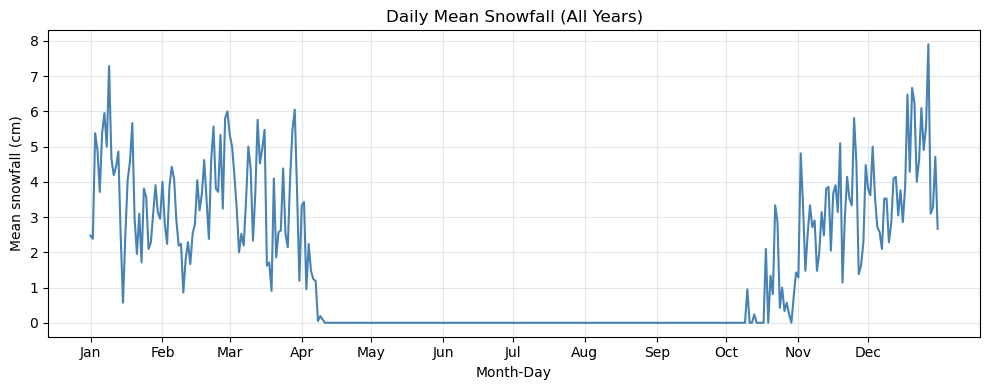

In [36]:
# `series` is the daily mean snowfall indexed by dummy-year dates (from earlier steps)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(x=series.index, y=series.values, ax=ax, color="steelblue")

ax.set_title("Daily Mean Snowfall (All Years)")
ax.set_xlabel("Month-Day")
ax.set_ylabel("Mean snowfall (cm)")
ax.grid(True, alpha=0.3)

# Optional: cleaner month ticks
ax.set_xticks(series.resample("MS").mean().index)
ax.set_xticklabels(series.resample("MS").mean().index.strftime("%b"), rotation=0)

plt.tight_layout()
plt.show()
